# Previsão de Séries Temporais com Programação Genética
Este exercício tem o objetivo de utilizar Programação Genética para gerar um modelo de previsão de séries temporais. Os dados utilizados são referente ao número mensal de passageirosde linhas aéreas internacionais (em milhares/mês), desde janeir/1949 a dezembro/1960, conforme figura abaixo.
![grafico](serie-grafico.png)

O primeiro passo foi criar o dataset com os dados da planilha fornecida. Separou-se em dois datasets: treinamento e teste.  
Como **janela de periodicidade**, observou-se que a cada 12 passo o padrão se repetia, o que corresponde a um ano **(12 meses)**. Sendo assim utilizou-se esse valor para gerar uma matriz que contivesse 12 entradas e uma saída.

In [1]:
import numpy as np
from numpy import genfromtxt

#lendo do arquivo
data = genfromtxt('serie.txt')
data = np.array([[data[index+pos] for pos in range(13)] for index in range(data.size - 12)])

#separando os conjuntos
DATA_TRAIN_SIZE = data[:,1].size - 12
data_train = data[:DATA_TRAIN_SIZE,:]
data_test = data[DATA_TRAIN_SIZE:,:]

Para a implementação do algoritmo de Programação Genética, utilizou-se o **DEAP** *(Distributed Evolutionary Algorithms in Python)*. Abaixo realiza-se o import dos modulos que serão utilizados.

In [2]:
import operator
import math
import random

from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp

Define-se agora a estrutura da árvore que será gerada nas evoluções da PG. Esta árvore terá 12 entradas que correspnde a janela definida de 12 meses. Também serão definidas as funções e os terminais utilizados.

In [3]:
#definicao da estrutura de um conjunto que terá 12 entradas
pset = gp.PrimitiveSet("MAIN", 12)

pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)
pset.addPrimitive(operator.neg, 1)
pset.addPrimitive(math.cos, 1)
pset.addPrimitive(math.sin, 1)

In [4]:
pset.addEphemeralConstant("rand101", lambda: random.randint(-180,180)) #terminal que gera um numero aleatorio entre [-1,1]
pset.addTerminal(math.pi)

Os argumentos(entradas) serão renomeados para facilitar o entendimento da arvore gerada posteriormente. Cada argumento representa um mês do ano.

In [6]:
pset.renameArguments(ARG0='t-12')
pset.renameArguments(ARG1='t-11')
pset.renameArguments(ARG2='t-10')
pset.renameArguments(ARG3='t-9')
pset.renameArguments(ARG4='t-8')
pset.renameArguments(ARG5='t-7')
pset.renameArguments(ARG6='t-6')
pset.renameArguments(ARG7='t-5')
pset.renameArguments(ARG8='t-4')
pset.renameArguments(ARG9='t-3')
pset.renameArguments(ARG10='t-2')
pset.renameArguments(ARG11='t-1')

Na sequencia, será definido o alicerce da PG:  
- característica do problema(minimização ou maximização)  
- método de geração da população(grow, full, half and half)  
- função de fitness  
- função de crossover  
- função de mutação  
- função de seleção  
- definição da profundidade máxima da árvore

In [7]:
#característica do problema
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
#tipo do indivíduo = árvore
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
#método de geração da população(árvore)
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
#compila a arvore gerada em uma função
toolbox.register("compile", gp.compile, pset=pset)

#função de fitness que compara a arvore gerada com os dados de treinamento
def fitness(individual):
    # Tranforma a expressao da arvore em um função invocável
    func = toolbox.compile(individual)
    
    # calcula o erro quadrado médio entre a expressao e o valor real 'y'
    sqerrors = ((func(x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12)-y)**2 for x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,y in data_train)
    
    return math.fsum(sqerrors) / len(data_train),

#define para o framework qual será a função de fitness utilizada
toolbox.register("evaluate", fitness)
#define o operador de seleção como torneio de tamanho 3
toolbox.register("select", tools.selTournament, tournsize=3)
#define função de cruzamento como corte em um ponto
toolbox.register("mate", gp.cxOnePoint)
#cria função de mutação utilizando o método de geração de árvore full
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
#define a função de mutação para o framework
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

#quando houver cruzamento o tamanho da arvore nao pode passar de 50
toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=50))
#quando houver muatção o tamanho da arvore nao pode passar de 50
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=50))

Com toda a estrutura definida agora é possível criar a função que de fato irá rodar  algoritmo.

In [8]:
def algorithm():
    random.seed(318)
    #CXPB  - Probabilidade de crossover
    #MUTPB - Probabilidade de mutação
    #NGEN  - Numero de gerações
    CXPB, MUTPB, NGEN = 0.6, 0.1, 200

    pop = toolbox.population(n=300)
    hof = tools.HallOfFame(1)
    
    stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
    stats_size = tools.Statistics(len)
    mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
    mstats.register("avg", np.mean)
    mstats.register("std", np.std)
    mstats.register("min", np.min)
    mstats.register("max", np.max)

    # Realiza a chamada do algortimo definido no capitulo 7 do KOZA.
    # Passa como parâmetros:
    #     - população
    #     - toolbox que é o objeto que representa o framework DEAP
    #     - parametros evolucionais (probabilidades de crossover e mutação e gerações)
    #     - objeto com os placeholders de estatística
    #     - halloffame - individuo(s) selecionado(s)
    #     - verbos que representa se será impresso nas saida a evolução do algoritmo
    pop, log = algorithms.eaSimple(pop, toolbox, CXPB, MUTPB, NGEN, stats=mstats,
                                   halloffame=hof, verbose=True)
    # print log
    return pop, log, hof

In [9]:
pop, log, hof = algorithm()

   	      	                     fitness                      	              size             
   	      	--------------------------------------------------	-------------------------------
gen	nevals	avg        	max        	min    	std       	avg 	max	min	std    
0  	300   	1.39632e+13	4.18868e+15	1053.83	2.4143e+14	3.13	7  	2  	1.28313
1  	185   	3.80809e+12	1.1424e+15 	1053.83	6.58464e+13	3.29333	10 	1  	1.39306
2  	182   	6.63357e+12	1.00686e+15	1003.58	8.09788e+13	3.51333	8  	1  	1.44331
3  	185   	1.39188e+13	4.1756e+15 	1013.91	2.40676e+14	4.09667	11 	1  	1.84409
4  	207   	1.17156e+08	1.0649e+10 	288.25 	1.01631e+09	4.21333	11 	1  	1.97513
5  	183   	6.46653e+07	9.28428e+09	448.25 	6.92549e+08	3.94667	12 	1  	2.04381
6  	166   	2.73126e+07	8.18657e+09	448.25 	4.71862e+08	3.81   	11 	1  	2.14645
7  	191   	1.87103e+08	3.94031e+10	448.25 	2.3678e+09 	3.72333	11 	1  	2.20759
8  	200   	6.55669e+07	1.05502e+10	448.25 	7.71942e+08	3.64333	13 	1  	2.02553
9  	202   	1.1445e+08 	8.87393

## Resultados

### 1. Análise de parâmetros e funções

O individuo nessa implementação é gerado utilizando o método **HalfAndHalf** onde metade da expressao é gerada com o **grow** e outra metade com **full**.  
Utilizou-se uma probalidade de crossover de 60% e de mutaçao de 10%. Como operador de crossover escolheu-se o cruzamento de ponto único ounde escolhe-se um ponto aleatório da árvore, corta-o e troca com o da outra árvore. Como operador de mutação, escolheu-se randomicamente um ponto em um individuo(árvore), então trocou-se a sub-arvore no ponto gerando um pedaço utilizando o método **full** onde cada folha tem profundidade máxima entre 0 e 2.  
Para função de fitness utilizou-se o erro quadrado médio.  

Foram feitos varios testes(cenários) com combinações de funções para a Programação Genética, que podem ser resumidos nos três abaixo:
- Cenário simplista
    - Funções: soma e subtração.  
    - Terminais: randomico entre [-1,1]  
    - Obteve um erro médio de aproximadamente 9% e uma função bem simples. $f = x2+13$   

- Cenário coerente  
    - Funções: soma, subtração, coseno, seno, negação, multiplicação.  
    - Terminais: randomico entre [-180,180]  
    - Obteve um erro médio de aproximadamente 5% e um função simples também.  $f = x1+27$

- Cenário complexo
    - Funções: soma, subtração, divisão, coseno, seno, negação, multiplicação, exponencial
    - Terminais: randomico entre [-180,180]  
    - Obteve um erro médio superior a 10% e função muito complexa. Árvore muito grande.
    
Sendo assim o cenário coerente foi utilizado para apresentar os demais resultados.

### 2. Melhor expressão-S obtida

In [10]:
str(hof[0])

'add(26, add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(3.141592653589793, x1), sin(x6)), sin(sub(add(x12, x1), sin(sub(add(x12, x1), sin(sub(3.141592653589793, x1))))))), sin(sin(sin(x6)))), sin(sub(neg(add(add(add(26, x1), sin(x6)), mul(x12, x8))), sin(x6)))), sin(x6)), sin(sub(neg(add(add(add(26, x1), sin(sin(add(x6, sin(x8))))), 26)), x6))), sin(sub(add(x12, x1), sin(sub(3.141592653589793, x1))))), sin(sin(x6))), sin(sub(sin(sub(neg(add(add(add(26, x1), sin(x6)), mul(x12, x8))), sin(x6))), sin(x6)))), sin(sub(add(x12, x1), sin(sub(3.141592653589793, x1))))), sin(sin(x6))), sin(sub(sin(add(x6, sin(x8))), x6))), sin(sin(x6))), sin(sub(neg(add(add(add(26, x1), sin(x6)), mul(x12, x8))), sin(x6)))), sin(x6)), sin(sub(neg(add(add(add(26, x1), sin(sin(add(x6, sin(x8))))), 26)), x6))), sin(sub(add(x12, add(sub(96, x1), neg(3.141592653589793))), sin(sub(3.141592653589793, x1)))))

### 3. Equação correspondente(simplificada)

$$f(x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12) = x1 + 27$$

### 4. Planilha com os dados obtidos

In [11]:
import pandas as pd

#Colunas da tabela
cols = ['x1','x2','x3','x4','x5','x6','x7','x8','x9','x10','x11','x12','VALOR REAL','VALOR PG','ERRO(%)']

#Compila  melhor indivíduo chamar a funçã com os resultados
function = gp.compile(hof[0],pset)
table_train = []
for x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,y in data_train:
    pg = function(x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12)
    table_train.append([x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,y,pg,round(abs(100-pg*100/y),2)])

table_test = []    
for x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,y in data_test:
    pg = function(x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12)
    table_test.append([x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,y,pg,round(abs(100-pg*100/y),2)])

print('\n========\n|TREINO|\n========')
table_train = np.array(table_train)
df_train = pd.DataFrame(table_train,columns = cols)
print(df_train.to_string())

print('\n=======\n|TESTE|\n=======')
table_test = np.array(table_test)
df_test = pd.DataFrame(table_test,columns = cols)
print(df_test.to_string())



|TREINO|
        x1     x2     x3     x4     x5     x6     x7     x8     x9    x10    x11    x12  VALOR REAL    VALOR PG  ERRO(%)
0    112.0  118.0  132.0  129.0  121.0  135.0  148.0  148.0  136.0  119.0  104.0  118.0       115.0  135.274079    17.63
1    118.0  132.0  129.0  121.0  135.0  148.0  148.0  136.0  119.0  104.0  118.0  115.0       126.0  150.974934    19.82
2    132.0  129.0  121.0  135.0  148.0  148.0  136.0  119.0  104.0  118.0  115.0  126.0       141.0  158.901605    12.70
3    129.0  121.0  135.0  148.0  148.0  136.0  119.0  104.0  118.0  115.0  126.0  141.0       135.0  144.649215     7.15
4    121.0  135.0  148.0  148.0  136.0  119.0  104.0  118.0  115.0  126.0  141.0  135.0       125.0  140.657204    12.53
5    135.0  148.0  148.0  136.0  119.0  104.0  118.0  115.0  126.0  141.0  135.0  125.0       149.0  161.325060     8.27
6    148.0  148.0  136.0  119.0  104.0  118.0  115.0  126.0  141.0  135.0  125.0  149.0       170.0  174.326168     2.54
7    148.0  136.0  119

### 5. Gráfico com os dados reais e os gerados pela função obtida por PG

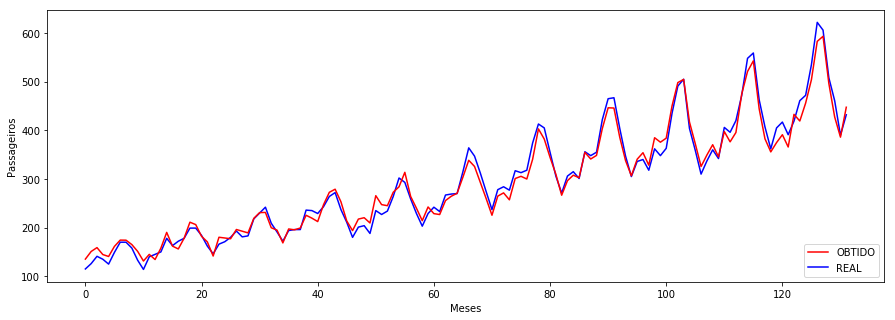

In [12]:
import matplotlib.pyplot as plt

meses = np.arange(132)


fig, ax1 = plt.subplots()
ax1.set_xlabel("Meses")
ax1.set_ylabel("Passageiros")

line1 = ax1.plot(meses, np.concatenate((table_train[:,12],table_test[:,12]),axis=0), "b-", label="REAL")
line2 = ax1.plot(meses, np.concatenate((table_train[:,13],table_test[:,13]),axis=0), "r-", label="OBTIDO")


lns = line2 + line1
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=4)

fig.set_size_inches(15, 5, forward=True)

plt.show()

In [13]:
error_final = np.concatenate((table_train[:,14],table_test[:,14]),axis=0)
print('Erro médio treino: {}%'.format(sum(table_train[:,14])/len(table_train)))
print('Erro médio teste: {}%'.format(sum(table_test[:,14])/len(table_test)))
print('Erro médio total: {}%'.format(sum(error_final)/len(error_final)))

Erro médio treino: 4.717833333333335%
Erro médio teste: 4.733333333333333%
Erro médio total: 4.7192424242424265%


### 6. Considerações finais

- Aumentando-se o numero de gerações não contribui para uma melhora do erro.  
- As equações que envolviam seno e coseno não apresentaram-se melhor.  
- Os dados iniciais apresentam um erro maior pois, devido a estrutura do problema, eles nao têm dados suficientes de treinamento.  
- A adição e funções mais complexas como exponencial implica em incluir restrições para não dar erro ao calcular o fitness ou gerar um filho.